## Prompt Chaining

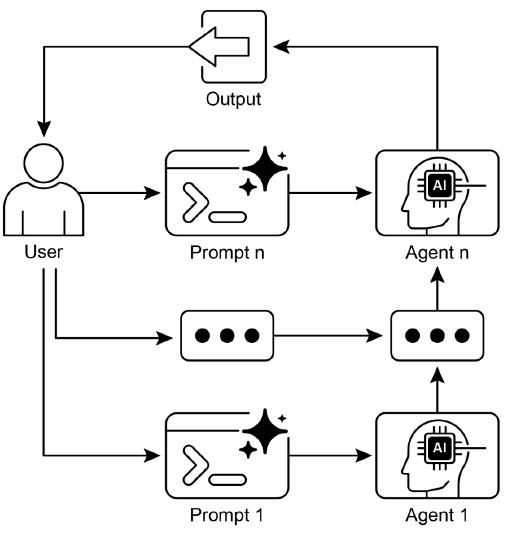

#### Definition:
- Prompt chaining (or Pipeline Pattern) is a divide-and-conquer approach where a complex task is broken into smaller, sequential prompts.
- Prompt chaining provides a standardized solution by `breaking down a complex problem into a sequence of smaller, interconnected sub-tasks`. Each step in the chain uses a focused prompt to perform a specific operation, significantly improving reliability and control. The output from one prompt is passed as the input to the next, creating a logical workflow that progressively builds towards the final solution. This modular, divide-and-conquer strategy makes the process more manageable, easier to debug, and allows for the integration of external tools or structured data formats between steps. This pattern is foundational for developing sophisticated, multi-step Agentic systems that can plan, reason, and execute complex workflows.

#### Mechanism:
- Each prompt handles a sub-task; its output feeds into the next prompt → forming a dependency chain.

#### Goal:
- Improve clarity, reliability, interpretability, and control over multi-step reasoning.

#### Benefit:
- Enables modular, debuggable workflows that can integrate external tools or APIs.

#### Significance:
- Foundation for agentic systems — supports autonomous planning, reasoning, and multi-step action.

#### Rule of thumb: 
Use this pattern when:
- A task is too complex for a single prompt,
- involves multiple distinct processing stages,
- requires interaction with external tools between steps, or
- when building Agentic systems that need to perform multi-step reasoning and maintain state.

#### Example usecase:
1. Initial `Prompt (Summarization)`: "Summarize the key findings of the following market research report: [text]." The model's sole focus is summarization, increasing the accuracy of this initial step.
2. Second `Prompt (Trend Identification)`: "Using the summary, identify the top three emerging trends and extract the specific data points that support each trend: [output from step 1]." This prompt is now more constrained and builds directly upon a validated output.
3. Third `Prompt (Email Composition)`: "Draft a concise email to the marketing team that outlines the following trends and their supporting data: [output from step 2]."

In [20]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

from IPython.display import display, Image

In [9]:
load_dotenv()

True

In [10]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [13]:
# 1️⃣ Define our State Schema
# Each step will add a field to the shared state.
class MarketState(MessagesState):
    text: str = None
    summary: str = None
    trends: str = None
    email: str = None

In [25]:
# Step 1: Summarization
def summarize(state: MarketState):
    prompt = f"""
    You are a market research analyst.
    Summarize the key findings of this market research report:
    ---
    {state["text"]}
    ---
    Only provide a concise, factual summary.
    """
    response = llm.invoke(prompt)
    return {"summary": response.content.strip()}

In [26]:
# Step 2: Trend Identification
def identify_trends(state: MarketState):
    prompt = f"""
    Using the following summary, identify the top three emerging trends
    and extract the supporting data points.
    Summary:
    ---
    {state["summary"]}
    ---
    Return in strict JSON format:
    {{
      "trends": [
        {{"trend_name": "string", "supporting_data": "string"}}
      ]
    }}
    """
    response = llm.invoke(prompt)
    return {"trends": response.content.strip()}

In [27]:
# Step 3: Email Composition
def compose_email(state: MarketState):
    prompt = f"""
    Draft a concise, professional email to the marketing team
    outlining the following trends and their supporting data:
    ---
    {state["trends"]}
    ---
    """
    response = llm.invoke(prompt)
    return {"email": response.content.strip()}

In [28]:
# 3️⃣ Build the Graph
# -------------------

graph = StateGraph(MarketState)

graph.add_node("summarize", summarize)
graph.add_node("identify_trends", identify_trends)
graph.add_node("compose_email", compose_email)

# Define flow
graph.add_edge(START, "summarize")
graph.add_edge("summarize", "identify_trends")
graph.add_edge("identify_trends", "compose_email")
graph.add_edge("compose_email", END)

workflow = graph.compile()

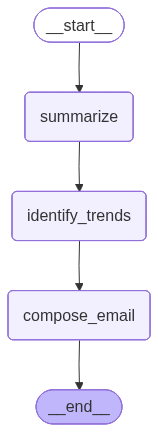

In [29]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [30]:
# 5️⃣ Run the pipeline
food_report = """
The global food retail sales generate over $4 trillion per year. The food industry encompasses several categories of food including: dairy, seafood, eggs, fruit and vegetables, luxury foods, organic food, meat, packaged food, condiments, and cereal-based products. There is the spotlight on sustainability efforts, but the focus has shifted
toward food loss and waste. Many consumers are continuously looking at how they can derive ingredients from their waste streams, while food waste at the consumer and retailer end of the food chain is also set for increased scrutiny. And when negative impacting issues such as the horse meat scandal that kept the food industry in the news for all the wrong reasons in 2012, and food and out of stock scares take their toll on consumer confidence, lately companies have finally understood and worked a cut out in order to regain consumer trust. And as a result, more manufacturers are looking to highlight the origins of their products and ingredients. Therefore, in 2014, consumers can expect to see manufacturers begin to incorporate foraged, hyper-local ingredients into accessible formats and recognizable products.
 
There is a reason why consumers of late are looking at back to basics pleasures, pleasures such as home-cooked food. To tap into this trend, manufacturers are adapting what is known as value packaging, and good value claims on the products. An increasing global population and a shift towards convenience food has continued to push the industry forward and that is why changing habits in food culture have come to mean varied tastes while increasing demand for ethnic foods and newer formats, newer formats such as microwaveable food products. More than anything, convenience is a key as consumers have started to demand and started to focus on processed, ready-to-eat, packaged goods, that is the reason demand has exceeded supply in certain food markets.
 
According to MarketLine, the world fruit and vegetables market is predicted to reach in excess of $736 billion by the end of 2015, which will record a massive 25% growth by the end of 2018. Vegetables lead the segment at almost 64%. The Asia-Pacific region accounts for over 45% of the overall market. Meat leads the segment at over 40% of overall market value. The EU holds close to 38% of the market. Brazil Foods is the world leader in the frozen foods market, accounting for 5% of overall market share. According to Global Industry Analysts, the world market for muscle food packaging, which encompasses meat, seafood and poultry packaging, is expected to exceed $31 billion by 2017. Technological advances, better packaging practices and packaging facilitating smaller portions are fueling the market.

"""

In [31]:
final_state = workflow.invoke({"text": food_report})

In [32]:
print("=== SUMMARY ===")
print(final_state["summary"])
print("\n=== TRENDS ===")
print(final_state["trends"])
print("\n=== EMAIL ===")
print(final_state["email"])

=== SUMMARY ===
The global food retail industry generates over $4 trillion annually, covering diverse categories such as dairy, seafood, meat, and organic foods. A key focus is shifting toward sustainability, particularly regarding food loss and waste, with consumers increasingly seeking ways to utilize waste ingredients. Following past scandals, manufacturers are emphasizing product origins to rebuild consumer trust. 

There is a growing trend toward home-cooked meals, leading manufacturers to adopt value packaging and emphasize good value claims. Convenience is a significant demand driver, with increased interest in processed and ready-to-eat foods. 

The world fruit and vegetables market is projected to exceed $736 billion by the end of 2015, reflecting a 25% growth by 2018, with vegetables comprising 64% of this segment. The Asia-Pacific region represents over 45% of the overall market. The meat sector constitutes over 40% of total market value, and the EU captures 38%. The world m

Code Generation and Refinement: The generation of functional code is typically a multi-stage process, requiring a problem to be decomposed into a sequence of discrete logical operations that are executed progressively
- Prompt 1: Understand the user's request for a code function. Generate pseudocode or an outline.
- Prompt 2: Write the initial code draft based on the outline.
- Prompt 3: Identify potential errors or areas for improvement in the code (perhaps using a static analysis tool or another LLM call).
- Prompt 4: Rewrite or refine the code based on the identified issues.
- Prompt 5: Add documentation or test cases.